# Methane Problem - 3D + time

Source s(t,x) = exp(-.5(x-c)^2)

kx,ky,kz = 1
u,v,w = 1

u = wind vector
dc/dt + u*dc/dx + v * dc/dy + w * dc/dz + c(du/dx + dv/dy + dw/dz) - k_x * d2c/dx2 - k_y * d2c/dy2 - k_z * d2c/dz2 = s

In [12]:
from pde_solver import PINN
import numpy as np
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from scipy.stats import beta
import scipy.stats.qmc as qmc
from scipy.stats.qmc import LatinHypercube as lhc
from itertools import product
from scipy.integrate import quad
# print("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("CUDA is available! PyTorch is ready to use the GPU.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def calculate_edges(min_vals, max_vals):
    n = len(min_vals)
    
    # Generate all vertices
    vertices = list(product(*zip(min_vals, max_vals)))
    
    edges = []
    
    # Generate edges
    for i, v1 in enumerate(vertices):
        for j, v2 in enumerate(vertices):
            if i < j:  # Avoid duplicates
                # Check if they differ by exactly one coordinate
                diff_count = sum([1 for k in range(n) if v1[k] != v2[k]])
                if diff_count == 1:
                    edges.append((v1, v2))
    
    return edges
              
def linspace_edges(min_vals, max_vals,num):
    edges = calculate_edges(min_vals,max_vals)
    X = list()
    for i in range(len(min_vals)):
         X.append(list())
    for edge in edges:
         for i in range(len(min_vals)):
            X[i].append(np.linspace(edge[0][i],edge[1][i],num))
    for i in range(len(X)):
         X[i] = np.concatenate(X[i])
    return X

       
n = 1000
# Training data
sampler = lhc(d=4)
sample = sampler.random(n=n)
dm_lb = [0,0,0,0]
dm_ub = [10,10,10,10]
lhc_pts = qmc.scale(sample,dm_lb,dm_ub)
X1 = np.transpose(lhc_pts)[0]
X2 = np.transpose(lhc_pts)[1]
X3 = np.transpose(lhc_pts)[2]
X4 = np.transpose(lhc_pts)[3]

le = linspace_edges(dm_lb,dm_ub,4)
X1 = torch.tensor(np.concatenate((X1,le[0],np.linspace(0,10,100), np.random.rand(250)*3))).float()
X2 = torch.tensor(np.concatenate((X2,le[1],[0]*100,np.random.rand(250)*.5))).float()
X3 = torch.tensor(np.concatenate((X3,le[2],[0]*100,np.random.rand(250)*.5))).float()
X4 = torch.tensor(np.concatenate((X4,le[3],[5]*100,np.random.rand(250)*.5+4.75))).float()

icn = 60
bn = 20
le = linspace_edges(dm_lb[1:],dm_ub[1:],bn)
tbn = len(le[0])
X10 = torch.tensor([0] * (tbn + icn)).float()
X20 = torch.tensor(np.concatenate((le[0],
                    np.random.rand(icn) * (dm_ub[1] - dm_lb[1]) + dm_lb[1] ))).float()


X30 = torch.tensor(np.concatenate((le[1],
                    np.random.rand(icn) * (dm_ub[2] - dm_lb[2]) + dm_lb[2]))).float()

X40 = torch.tensor(np.concatenate((le[2],
                    np.random.rand(icn) * (dm_ub[3] - dm_lb[3]) + dm_lb[3]))).float()

U0 = torch.tensor([0] * (tbn + icn)).float()

X1 = torch.concat([X1,X10])
X2 = torch.concat([X2,X20])
X3 = torch.concat([X3,X30])
X4 = torch.concat([X4,X40])

X1_np = X1.detach().numpy()
X2_np = X2.detach().numpy()
X3_np = X3.detach().numpy()
X4_np = X4.detach().numpy()

z0 = 5
q = 100
D = 0.2
physics_loss = {"conditions": [lambda u, x2, x3, x4, ux1, ux2, ux3,ux4, ux2x2, ux3x3, ux4x4: ux1 + 1 * ux2 + 1 * ux3 + 0 * ux4 - D*( ux2x2 + ux3x3 + ux4x4) -  ((torch.abs(x2)+torch.abs(x3)+torch.abs(x4-z0) < .000001).int() * q),
                               lambda u : torch.abs(torch.abs(u) - u)],

                "condition_weights" : [1,10],
                "points" : {"x1" : X1,
                            "x2" : X2,
                            "x3" : X3,
                            "x4" : X4},
                "point_weights" : [1 for _ in range(len(X2))]}

boundary_loss = {"points" : {"u"  : U0,
                             "x1" : X10,
                             "x2" : X20,
                             "x3" : X30,
                             "x4" : X40},
                "point_weights" : [100 for _ in range(len(X20))]}


model = PINN(layers=[4,100,100,100,1], physics_loss = physics_loss, boundary_loss = boundary_loss)
# model.to(device)
optimizer = optim.Adam(model.parameters(),lr=.0001)

# Create the learning rate scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
scheduler = None

max_epochs = 25000
u=20
v=20
vz=1
vy=(2*D)
evaluate = lambda t,x,y,z : (q/(((2*np.pi)**1.5)*((2*D*t)**3/2))) * np.exp(-1*((x-u*t)**2 + (y-v*t)**2)/(2*(2*D*t)**(2*1/2))) * (np.exp((-1*(z-z0)**2)/(2*(D*2*t)**(2*1/2))) + np.exp((-1*(z+z0)**2)/(2*(D*2*t)**(2*1/2))))
def actual(t_input,x_input,y_input,z_input):
 result, error = quad((lambda x, y, z : lambda t : (evaluate(t,x,y,z)))(x_input,y_input,z_input), 0, t_input)
 return result

n = 1000
# Training data
X1_test = torch.tensor(np.random.rand(n)).float()*10
X2_test = torch.tensor(np.random.rand(n)).float()*10
X3_test = torch.tensor(np.random.rand(n)).float()*10
X4_test = torch.tensor(np.random.rand(n)).float()*10
X1_test_np = X1_test.detach().numpy()
X2_test_np = X2_test.detach().numpy()
X3_test_np = X3_test.detach().numpy()
X4_test_np = X4_test.detach().numpy()
status = []
for epoch in range(max_epochs+1):
            optimizer.zero_grad()
            loss_value = model.total_loss()
            loss_value.backward()
            optimizer.step()
            if scheduler != None:
                scheduler.step()
            if epoch % 500 == 0:
                pl, bl = model.physics_loss().item(), model.boundary_loss().item()
                print(pl,bl)
                status.append([epoch,pl+bl])
                # mae_train = np.mean(np.abs([actual(X1_np[i],X2_np[i],X3_np[i],X4_np[i]) for i in range(len(X1_np))] - 
                                    # model(torch.concat([X1.view(-1,1),X2.view(-1,1),X3.view(-1,1),X4.view(-1,1)],dim=1)).detach().numpy().flatten()))
                
                mae_test = np.mean(np.abs([actual(X1_test_np[i],X2_test_np[i],X3_test_np[i],X4_test_np[i]) for i in range(len(X1_test_np))] - 
                                     model(torch.concat([X1_test.view(-1,1), X2_test.view(-1,1), X3_test.view(-1,1),X4_test.view(-1,1)],dim=1)).detach().numpy().flatten()))
                status.append([epoch, loss_value.item(), mae_test])
                print(f'Epoch {epoch}, Loss: {"{:e}".format(loss_value.item())}, mae_test: {mae_test}')

CUDA is available! PyTorch is ready to use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3060
{'u': ['x1', 'x2', 'x3', 'x4'], 'ux2': ['x2'], 'ux3': ['x3'], 'ux4': ['x4']}
281.44891357421875 1.2107326984405518
Epoch 0, Loss: 2.830802e+02, mae_test: 1.8149552854961584


KeyboardInterrupt: 

In [8]:
import pandas as pd
status_df = pd.DataFrame(columns = ['epoch','loss','mae_train','mae_test'], data = status)
status_df = status_df[status_df['epoch'] % 500 == 0]
fig,ax = plt.subplots()

ax.plot(status_df['epoch'], status_df['loss'], 'r--', linewidth=2, marker='o', label='loss')
# ax.plot(status_df['epoch'], status_df['mae_train'], 'p--', linewidth=2, marker='o', label='mae_train')
ax.plot(status_df['epoch'], status_df['mae_test'], 'b--', linewidth=2, marker='o', label='mae_test')

ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

ValueError: 4 columns passed, passed data had 3 columns

In [14]:
x4 = np.linspace(0, 10, 5)
x2 = np.linspace(0, 10, 30)
x3 = np.linspace(0, 10, 30)
x1 = np.linspace(0.00000000001, 10, 5)

u=10
v=10
vz=4
vy=1
# evaluate = lambda t,x,y,z : (q/(((2*np.pi)**1.5)*(vy**2)*vz)) * np.exp(-1*((x-u*t)**2 + (y-v*t)**2)/(2*vy**2)) * (np.exp((-1*(z-z0)**2)/(2*vz**2)) + np.exp((-1*(z+z0)**2)/(2*vz**2)))


# Create meshgrid
X1, X4, X2, X3 = np.meshgrid(x1, x4, x2, x3)

# Convert to torch tensors
X2_torch = torch.tensor(X2, dtype=torch.float32)
X3_torch = torch.tensor(X3, dtype=torch.float32)
X1_torch = torch.tensor(X1, dtype=torch.float32)
X4_torch = torch.tensor(X4, dtype=torch.float32)

# Flatten the tensors to create input for the model
X2_flat = X2_torch.view(-1, 1)
X3_flat = X3_torch.view(-1, 1)
X1_flat = X1_torch.view(-1, 1)
X4_flat = X4_torch.view(-1, 1)
X2_flat_np = X2_torch.view(-1, 1).detach().numpy()
X3_flat_np = X3_torch.view(-1, 1).detach().numpy()
X1_flat_np = X1_torch.view(-1, 1).detach().numpy()
X4_flat_np = X4_torch.view(-1, 1).detach().numpy()
# Predict Z using the model and reshape to match the meshgrid
U_flat = model(torch.concat([X1_flat, X2_flat, X3_flat,X4_flat],dim=1)).detach()
U = U_flat.view(X1.shape).numpy()
# print(X1_flat_np)
U = np.array([actual(X1_flat_np[i],X2_flat_np[i],X3_flat_np[i],X4_flat_np[i]) for i in range(len(X2_flat_np))]).reshape(X1.shape)
global_min = np.min(U)
global_max = np.max(U)


C:\Users\andyh\AppData\Local\Temp\ipykernel_17636\1547410874.py:135: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad((lambda x, y, z : lambda t : (evaluate(t,x,y,z)))(x_input,y_input,z_input), 0, t_input)
C:\Users\andyh\AppData\Local\Temp\ipykernel_17636\1547410874.py:135: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, error = quad((lambda x, y, z : lambda t : (evaluate(t,x,y,z)))(x_input,y_input,z_input), 0, t_input)
C:\Users\andyh\AppData\Local\Temp\ipykernel_17636\1547410874.py:135: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad((lambda x, y, z : lambda t : (evaluate(

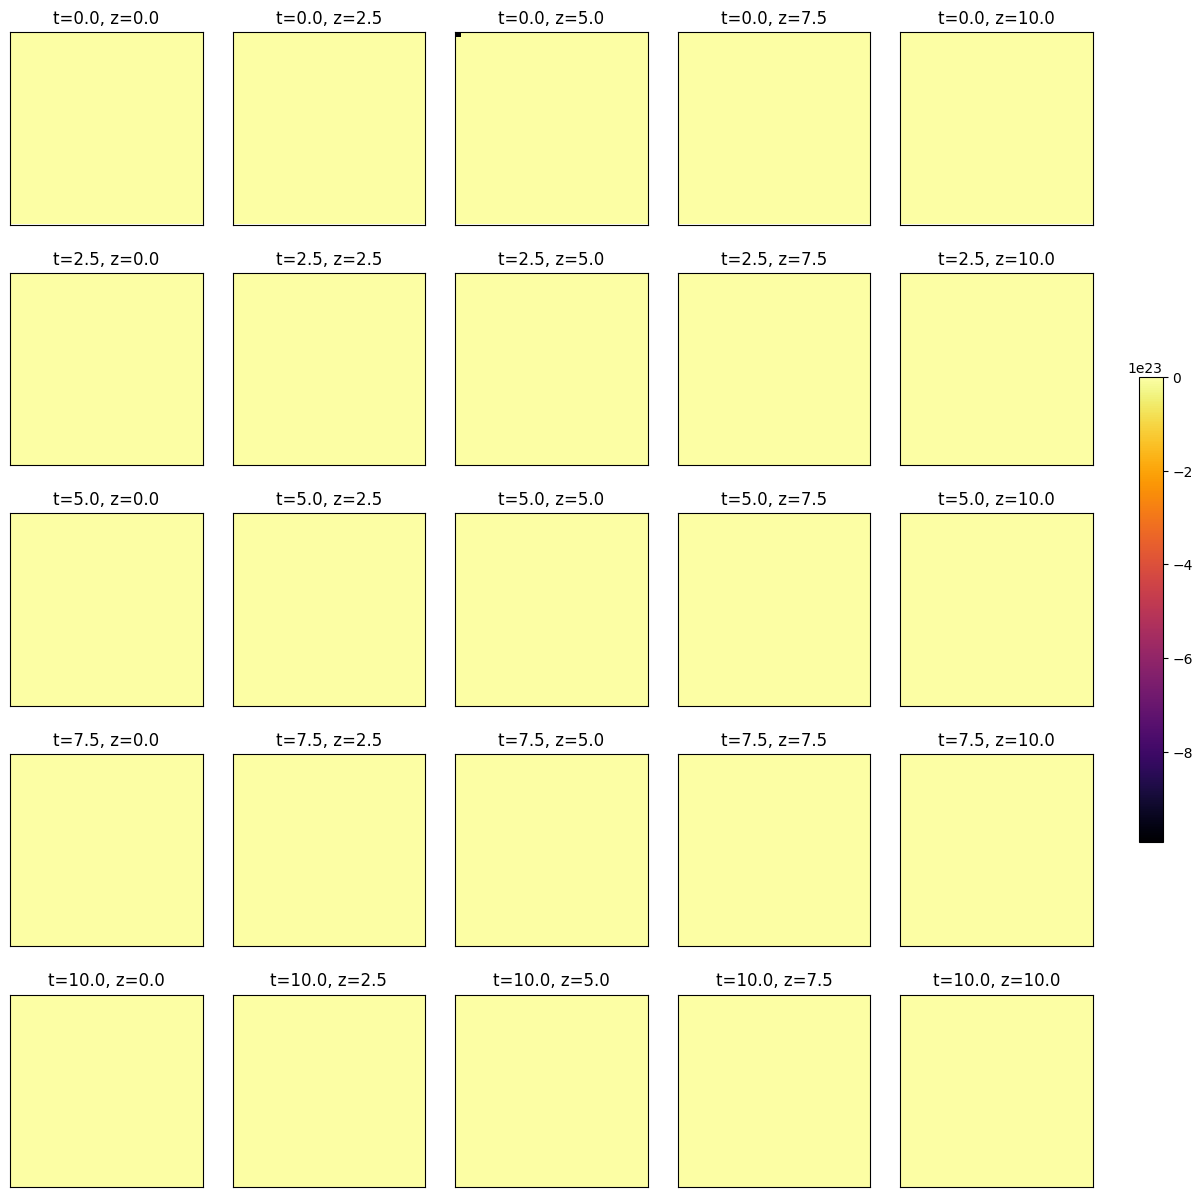

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


length = len(x1)
width = len(x4)
# Create a grid of subplots (4 rows x 5 columns)
fig, axs = plt.subplots(length, width, figsize=(15,15))

# Simulated example data (replace this with your actual data)
for i, ax in enumerate(axs.flat):
    j = i // width
    i = i % width
    data = U[i][j]
    im = ax.imshow(data, cmap='inferno', interpolation='nearest', vmin=global_min, vmax=global_max)
    
    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a time label at the top of each column
    
    ax.set_title(f't={round(x1[j],2)}, z={round(x4[i],2)}')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=.25)
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
# Show the plot
plt.show()

# Methane Problem - 3D + time

Source s(t,x) = exp(-.5(x-c)^2)

kx,ky,kz = 1
u,v,w = 1

u = wind vector
dc/dt + u*dc/dx + v * dc/dy + w * dc/dz + c(du/dx + dv/dy + dw/dz) - k_x * d2c/dx2 - k_y * d2c/dy2 - k_z * d2c/dz2 = s

In [27]:
from pde_solver import PINN
import numpy as np
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from scipy.stats import beta
import scipy.stats.qmc as qmc
from scipy.stats.qmc import LatinHypercube as lhc
from itertools import product
from scipy.integrate import quad

def calculate_edges(min_vals, max_vals):
    n = len(min_vals)
    
    # Generate all vertices
    vertices = list(product(*zip(min_vals, max_vals)))
    
    edges = []
    
    # Generate edges
    for i, v1 in enumerate(vertices):
        for j, v2 in enumerate(vertices):
            if i < j:  # Avoid duplicates
                # Check if they differ by exactly one coordinate
                diff_count = sum([1 for k in range(n) if v1[k] != v2[k]])
                if diff_count == 1:
                    edges.append((v1, v2))
    
    return edges
              
def linspace_edges(min_vals, max_vals,num):
    edges = calculate_edges(min_vals,max_vals)
    X = list()
    for i in range(len(min_vals)):
         X.append(list())
    for edge in edges:
         for i in range(len(min_vals)):
            X[i].append(np.linspace(edge[0][i],edge[1][i],num))
    for i in range(len(X)):
         X[i] = np.concatenate(X[i])
    return X
       
n = 1000
# Training data
sampler = lhc(d=4)
sample = sampler.random(n=n)
dm_lb = [0,0,0,0]
dm_ub =[10,10,10,10]
lhc_pts = qmc.scale(sample,dm_lb,dm_ub)
X1 = np.transpose(lhc_pts)[0]
X2 = np.transpose(lhc_pts)[1]
X3 = np.transpose(lhc_pts)[2]
X4 = np.transpose(lhc_pts)[3]

le = linspace_edges(dm_lb,dm_ub,4)
X1 = torch.tensor(np.concatenate((X1,le[0],np.linspace(0,10,50), np.random.rand(250)*5))).float()
X2 = torch.tensor(np.concatenate((X2,le[1],[0]*50,np.random.rand(250)*1))).float()
X3 = torch.tensor(np.concatenate((X3,le[2],[0]*50,np.random.rand(250)*1))).float()
X4 = torch.tensor(np.concatenate((X4,le[3],[5]*50,np.random.rand(250)*1+4.5))).float()
icn = 60
bn = 20
le = linspace_edges(dm_lb[1:],dm_ub[1:],bn)
tbn = len(le[0])
X10 = torch.tensor([0] * (tbn + icn)).float()
X20 = torch.tensor(np.concatenate((le[0],
                    np.random.rand(icn) * (dm_ub[1] - dm_lb[1]) + dm_lb[1] ))).float()


X30 = torch.tensor(np.concatenate((le[1],
                    np.random.rand(icn) * (dm_ub[2] - dm_lb[2]) + dm_lb[2]))).float()

X40 = torch.tensor(np.concatenate((le[2],
                    np.random.rand(icn) * (dm_ub[3] - dm_lb[3]) + dm_lb[3]))).float()

U0 = torch.tensor([0] * (tbn + icn)).float()




X1_dl_np = np.random.rand(200)*10
X2_dl_np = np.random.rand(200)*10
X3_dl_np = np.random.rand(200)*10
X4_dl_np = np.random.rand(200)*10
X1_dl = torch.tensor(X1_dl_np).float()
X2_dl = torch.tensor(X2_dl_np).float()
X3_dl = torch.tensor(X3_dl_np).float()
X4_dl = torch.tensor(X4_dl_np).float()


U_dl = torch.tensor([actual(X1_dl_np[i], X2_dl_np[i], X3_dl_np[i], X4_dl_np[i]) for i in range(len(X1_dl_np))])

physics_weights = np.concatenate(([1. for _ in range(len(X1))],[20. for _ in range(len(X10))],[20. for _ in range(len(X1_dl))]))

X1 = torch.concat([X1, X10, X1_dl])
X2 = torch.concat([X2, X20, X2_dl])
X3 = torch.concat([X3, X30, X3_dl])
X4 = torch.concat([X4, X40, X4_dl])

X1_np = X1.detach().numpy()
X2_np = X2.detach().numpy()
X3_np = X3.detach().numpy()
X4_np = X4.detach().numpy()
print(len(physics_weights))
print(len(X1))
# z0 = 5
# q = 10
physics_loss = {"conditions": [lambda u, x1, x2, x3, x4, ux1, ux2, ux3,ux4, ux2x2, ux3x3, ux4x4: ux1 + .7 * ux2 + .7 * ux3 + 0 * ux4 - 1*(ux2x2 + ux3x3  + ux4x4 ) -  (torch.abs(x1)+torch.abs(x2)+torch.abs(x3)+torch.abs(x4-z0) < .0000001).int() * q,
                               lambda u : torch.abs(torch.abs(u) - u)],

                "condition_weights" : [1,.2],
                "points" : {"x1" : X1,
                            "x2" : X2,
                            "x3" : X3,
                            "x4" : X4},
                "point_weights" : physics_weights*1}

boundary_loss = {"points" : {"u"  : U0,
                             "x1" : X10,
                             "x2" : X20,
                             "x3" : X30,
                             "x4" : X40},
                "point_weights" : [100 for _ in range(len(X20))]}

data_loss = {"points" : {"u"  : U_dl,
                             "x1" : X1_dl,
                             "x2" : X2_dl,
                             "x3" : X3_dl,
                             "x4" : X4_dl},
                "point_weights" : [1000 for _ in range(len(X1_dl))]}

model_dl = PINN(layers=[4,100,100,100,1], physics_loss = physics_loss, boundary_loss = boundary_loss, data_loss = data_loss)

optimizer = optim.Adam(model_dl.parameters(),lr=.0001)

# Create the learning rate scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.7)
scheduler = None

max_epochs = 25000
# u=.7
# v=.7
# vz=1
# vy=1
# evaluate = lambda t,x,y,z : (q/(((2*np.pi)**1.5)*(vy**2)*vz)) * np.exp(-1*((x-u*t)**2 + (y-v*t)**2))/(2*vy**2) * (
#      np.exp((-1*(z-z0)**2)/(2*vz**2)) + np.exp((-1*(z+z0)**2)/(2*vz**2)))
# def actual(t_input,x_input,y_input,z_input):
#  result, error = quad((lambda x, y, z : lambda t : (evaluate(t,x,y,z)))(x_input,y_input,z_input), 0, t_input)
#  return result

 


n = 1000
# Training data
# X1_test = torch.tensor(np.random.rand(n)).float()*10
# X2_test = torch.tensor(np.random.rand(n)).float()*10
# X3_test = torch.tensor(np.random.rand(n)).float()*10
# X4_test = torch.tensor(np.random.rand(n)).float()*10
# X1_test_np = X1_test.detach().numpy()
# X2_test_np = X2_test.detach().numpy()
# X3_test_np = X3_test.detach().numpy()
# X4_test_np = X4_test.detach().numpy()
status_dl = []
for epoch in range(max_epochs+1):
            optimizer.zero_grad()
            loss_value = model_dl.total_loss()
            loss_value.backward()
            optimizer.step()
            if scheduler != None:
                scheduler.step()
            if epoch % 100 == 0:
                pl, bl = model_dl.physics_loss().item(), model_dl.boundary_loss().item()
                print(pl,bl)
                status_dl.append([epoch,pl+bl])
                mae_train = np.mean(np.abs([actual(X1_np[i],X2_np[i],X3_np[i],X4_np[i]) for i in range(len(X1_np))] - 
                                    model_dl(torch.concat([X1.view(-1,1),X2.view(-1,1),X3.view(-1,1),X4.view(-1,1)],dim=1)).detach().numpy().flatten()))
                
                mae_test = np.mean(np.abs([actual(X1_test_np[i],X2_test_np[i],X3_test_np[i],X4_test_np[i]) for i in range(len(X1_test_np))] - 
                                     model_dl(torch.concat([X1_test.view(-1,1), X2_test.view(-1,1), X3_test.view(-1,1),X4_test.view(-1,1)],dim=1)).detach().numpy().flatten()))
                status_dl.append([epoch, loss_value.item(), mae_train, mae_test])
                print(f'Epoch {epoch}, Loss: {"{:e}".format(loss_value.item())}, mae_train: {mae_train}, mae_test: {mae_test}')

1928
1928
{'u': ['x1', 'x2', 'x3', 'x4'], 'ux2': ['x2'], 'ux3': ['x3'], 'ux4': ['x4']}
2.5953109359679667 0.7580243349075317
Epoch 0, Loss: 3.144625e+01, mae_train: 0.17234152242373127, mae_test: 0.1102253292363471
2.6064498390155695 0.32423433661460876
Epoch 100, Loss: 1.734678e+01, mae_train: 0.16424026031274136, mae_test: 0.09596089937401234
2.6138857608123462 0.23800328373908997
Epoch 200, Loss: 1.318936e+01, mae_train: 0.15985485657525206, mae_test: 0.0893971121069999
2.622568853688128 0.16383105516433716
Epoch 300, Loss: 1.069760e+01, mae_train: 0.15773409307498842, mae_test: 0.08742177220548356
2.629547752445602 0.15179258584976196
Epoch 400, Loss: 9.094346e+00, mae_train: 0.15649188591994867, mae_test: 0.08712678073915717
2.635591791623504 0.16622047126293182
Epoch 500, Loss: 7.947945e+00, mae_train: 0.15532171019773058, mae_test: 0.08660269507691964
2.639858253086472 0.17155739665031433
Epoch 600, Loss: 7.068011e+00, mae_train: 0.15277084978542954, mae_test: 0.0861312785646495

KeyboardInterrupt: 

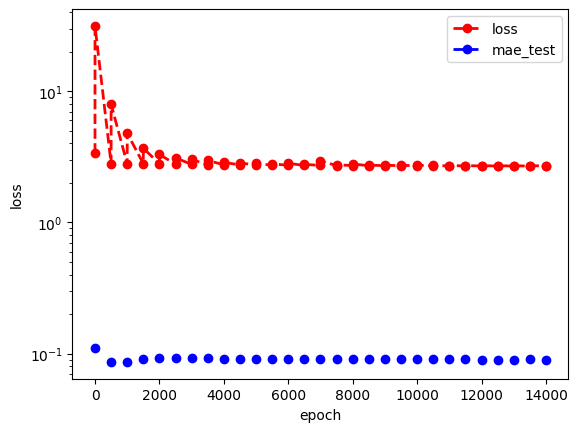

In [28]:
import pandas as pd
status_df = pd.DataFrame(columns = ['epoch','loss','mae_train','mae_test'], data = status_dl)
status_df = status_df[status_df['epoch'] % 500 == 0]
fig,ax = plt.subplots()

ax.plot(status_df['epoch'], status_df['loss'], 'r--', linewidth=2, marker='o', label='loss')
# ax.plot(status_df['epoch'], status_df['mae_train'], 'p--', linewidth=2, marker='o', label='mae_train')
ax.plot(status_df['epoch'], status_df['mae_test'], 'b--', linewidth=2, marker='o', label='mae_test')

ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()

In [30]:
x4 = np.linspace(0, 10, 5)
x2 = np.linspace(0, 10, 30)
x3 = np.linspace(0, 10, 30)
x1 = np.linspace(0, 10, 5)

# Create meshgrid
X1, X4, X2, X3 = np.meshgrid(x1, x4, x2, x3)

# Convert to torch tensors
X2_torch = torch.tensor(X2, dtype=torch.float32)
X3_torch = torch.tensor(X3, dtype=torch.float32)
X1_torch = torch.tensor(X1, dtype=torch.float32)
X4_torch = torch.tensor(X4, dtype=torch.float32)

# Flatten the tensors to create input for the model
X2_flat = X2_torch.view(-1, 1)
X3_flat = X3_torch.view(-1, 1)
X1_flat = X1_torch.view(-1, 1)
X4_flat = X4_torch.view(-1, 1)

# Predict Z using the model and reshape to match the meshgrid
U_flat = model(torch.concat([X1_flat, X2_flat, X3_flat,X4_flat],dim=1)).detach()
U = U_flat.view(X1.shape).numpy()

global_min = np.min(U)
global_max = np.max(U)


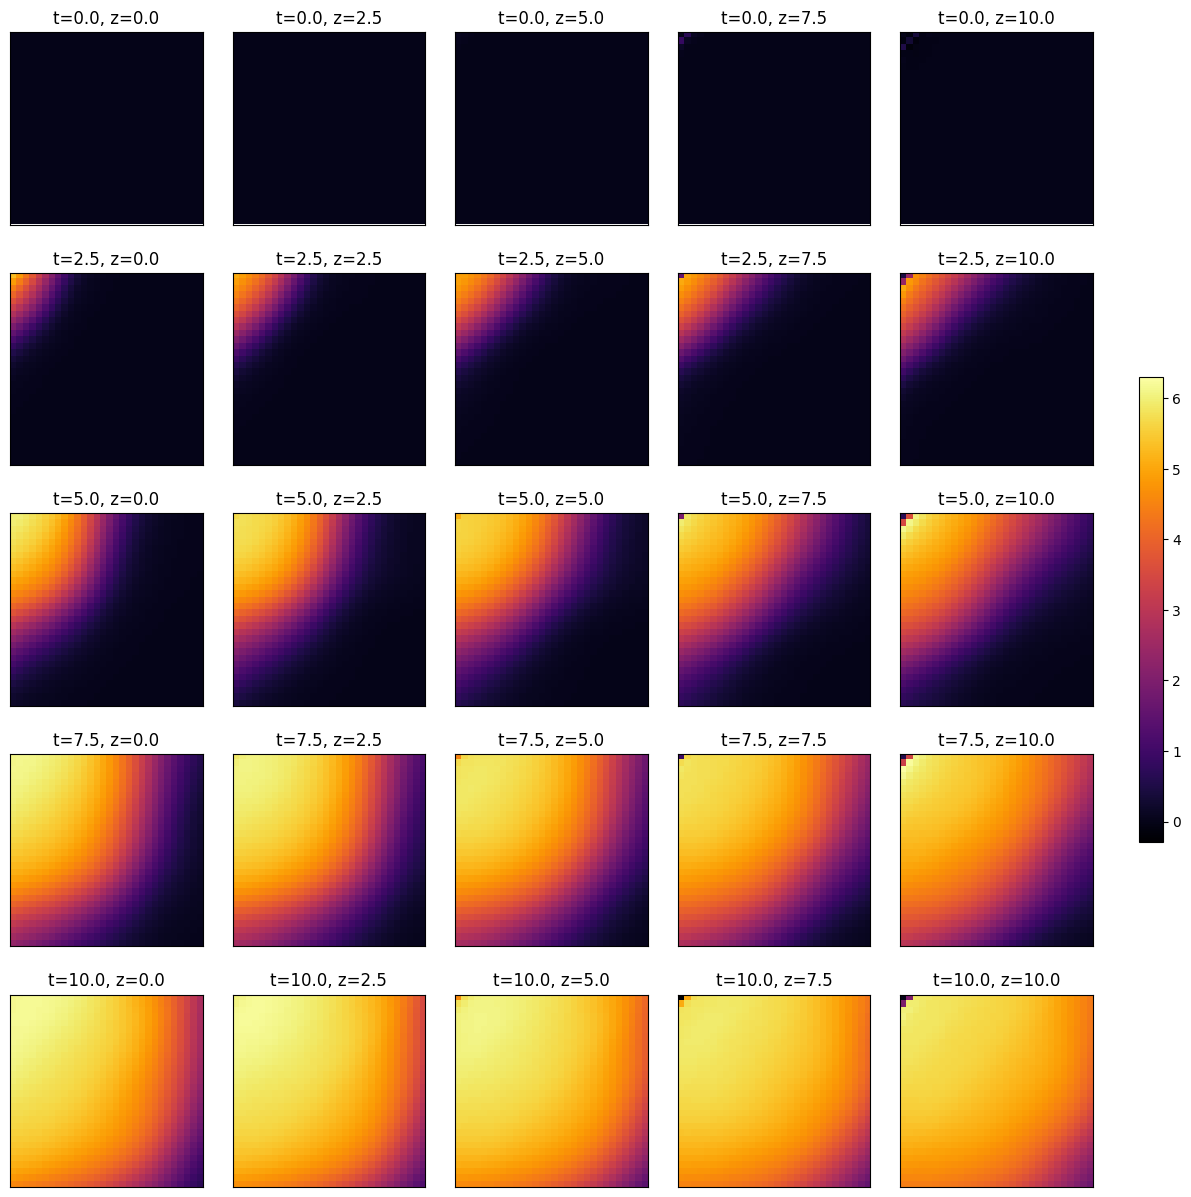

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle


length = len(x1)
width = len(x4)
# Create a grid of subplots (4 rows x 5 columns)
fig, axs = plt.subplots(length, width, figsize=(15,15))

# Simulated example data (replace this with your actual data)
for i, ax in enumerate(axs.flat):
    j = i // width
    i = i % width
    data = U[i][j]
    im = ax.imshow(data, cmap='inferno', interpolation='nearest', vmin=global_min, vmax=global_max)
    
    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a time label at the top of each column
    
    ax.set_title(f't={round(x1[j],2)}, z={round(x4[i],2)}')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=.25)
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
# Show the plot
plt.show()

In [ ]:
from scipy.integrate import quad

integral_helper = lambda x, y, z : lambda t : (actual(t,x,y,z))
print(integral_helper(1,1,1)(1))
result, error = quad(integral_helper(1,1,1), 0, 1)
print(f"Result: {result}, Error: {error}")


8.895923843282836e-05
Result: 4.795888823153356e-05, Error: 5.324506195007302e-19


In [ ]:
print(actual(1,1,1,1))

4.795888823153356e-05
